In [108]:
import pandas as pd
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

### Preparing the dataset 

Use only the following columns:

* `'engine_displacement'`,
* `'horsepower'`,
* `'vehicle_weight'`,
* `'model_year'`,
* `'fuel_efficiency_mpg'`

In [109]:
df = pd.read_csv('https://raw.githubusercontent.com/alexeygrigorev/datasets/master/car_fuel_efficiency.csv')
base = ['engine_displacement','horsepower','vehicle_weight','model_year','fuel_efficiency_mpg']
df = df[base]

### EDA

* Look at the `fuel_efficiency_mpg` variable. Does it have a long tail? 

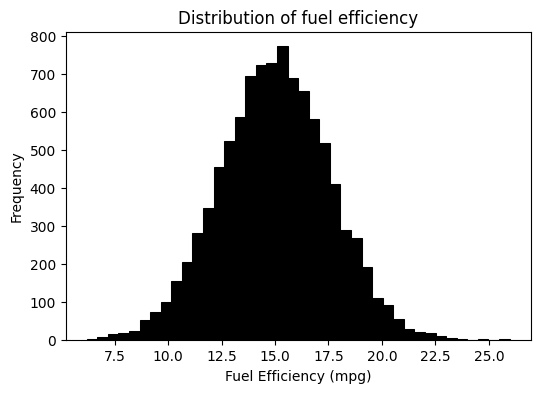

In [110]:
plt.figure(figsize=(6, 4))

sns.histplot(df.fuel_efficiency_mpg, bins=40, color='black', alpha=1)
plt.ylabel('Frequency')
plt.xlabel('Fuel Efficiency (mpg)')
plt.title('Distribution of fuel efficiency')

plt.show()

Does not have a long tail

### Question 1

There's one column with missing values. What is it?

In [111]:
df.isnull().sum()

engine_displacement      0
horsepower             708
vehicle_weight           0
model_year               0
fuel_efficiency_mpg      0
dtype: int64

horsepower has 708 missing values.

### Question 2

What's the median (50% percentile) for variable `'horsepower'`?

In [112]:
float(df.horsepower.median())

149.0

### Prepare and split the dataset

* Shuffle the dataset (the filtered one you created above), use seed `42`.
* Split your data in train/val/test sets, with 60%/20%/20% distribution.

Use the same code as in the lectures

In [113]:
def prepare_and_split(df, seed):
    df = df.copy()
    np.random.seed(seed)
    n = len(df)
    n_val = int(0.2 * n)
    n_test = int(0.2 * n)
    n_train = n - (n_val + n_test)
    idx = np.arange(n)
    np.random.shuffle(idx)
    df_shuffled = df.iloc[idx]
    df_train = df_shuffled.iloc[:n_train].copy().reset_index(drop = True)
    df_val = df_shuffled.iloc[n_train:n_train+n_val].copy().reset_index(drop = True)
    df_test = df_shuffled.iloc[n_train+n_val:].copy().reset_index(drop = True)
    return df_train, df_val, df_test

def prepare_X_y(df, fill_value=0):
    df = df.copy()
    df = df.fillna(fill_value)
    y = df.fuel_efficiency_mpg.values
    X = df.loc[ : , df.columns != 'fuel_efficiency_mpg'].values
    return X, y

def train_linear_regression_reg(X, y, r=0.0):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    reg = r * np.eye(XTX.shape[0])
    XTX = XTX + reg

    XTX_inv = np.linalg.inv(XTX)
    w = XTX_inv.dot(X.T).dot(y)
    
    return w[0], w[1:]

def rmse(y, y_pred):
    error = y_pred - y
    mse = (error ** 2).mean()
    return np.sqrt(mse)


In [114]:
df_train, df_val, df_test = prepare_and_split(df = df, seed = 42)

### Question 3

* We need to deal with missing values for the column from Q1.
* We have two options: fill it with 0 or with the mean of this variable.
* Try both options. For each, train a linear regression model without regularization using the code from the lessons.
* For computing the mean, use the training only!
* Use the validation dataset to evaluate the models and compare the RMSE of each option.
* Round the RMSE scores to 2 decimal digits using `round(score, 2)`
* Which option gives better RMSE?

In [115]:
horsepower_mean = float(df_train.horsepower.mean())
horsepower_mean

149.54476367006487

In [116]:
# Option 1

# Train
X_train, y_train = prepare_X_y(df_train, fill_value=0)
X_val, y_val = prepare_X_y(df_val, fill_value=0)

w_0, w = train_linear_regression_reg(X_train, y_train)
y_pred = w_0 + X_val.dot(w)
# Validate
score_opt1 = float(round(rmse(y_val, y_pred), 2))
score_opt1


0.52

In [117]:
# Option 2

# Train
X_train, y_train = prepare_X_y(df_train, fill_value=horsepower_mean)
X_val, y_val = prepare_X_y(df_val, fill_value=horsepower_mean)

w_0, w = train_linear_regression_reg(X_train, y_train)
y_pred = w_0 + X_val.dot(w)
# Validate
score_opt2 = float(round(rmse(y_val, y_pred), 2))
score_opt2

0.46

Replacing the nan with the mean gives the lower RMSE

### Question 4

* Now let's train a regularized linear regression.
* For this question, fill the NAs with 0. 
* Try different values of `r` from this list: `[0, 0.01, 0.1, 1, 5, 10, 100]`.
* Use RMSE to evaluate the model on the validation dataset.
* Round the RMSE scores to 2 decimal digits.
* Which `r` gives the best RMSE?

If multiple options give the same best RMSE, select the smallest `r`.

In [118]:
X_train, y_train = prepare_X_y(df_train, fill_value=0)
X_val, y_val = prepare_X_y(df_val, fill_value=0)
for r in [0, 0.01, 0.1, 1, 5, 10, 100]:
    # Train
    w_0, w = train_linear_regression_reg(X_train, y_train, r=r)
    y_pred = w_0 + X_val.dot(w)
    # Validate
    score = float(round(rmse(y_val, y_pred), 2))
    print(f"For regularisation with r = {r}, we get RMSE = {score}")

For regularisation with r = 0, we get RMSE = 0.52
For regularisation with r = 0.01, we get RMSE = 0.52
For regularisation with r = 0.1, we get RMSE = 0.52
For regularisation with r = 1, we get RMSE = 0.52
For regularisation with r = 5, we get RMSE = 0.52
For regularisation with r = 10, we get RMSE = 0.52
For regularisation with r = 100, we get RMSE = 0.52


r = 0 has the best regularisation

### Question 5 

* We used seed 42 for splitting the data. Let's find out how selecting the seed influences our score.
* Try different seed values: `[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]`.
* For each seed, do the train/validation/test split with 60%/20%/20% distribution.
* Fill the missing values with 0 and train a model without regularization.
* For each seed, evaluate the model on the validation dataset and collect the RMSE scores. 
* What's the standard deviation of all the scores? To compute the standard deviation, use `np.std`.
* Round the result to 3 decimal digits (`round(std, 3)`)

In [119]:
rmse_scores = []
for seed in [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]:
    df_train, df_val, df_test = prepare_and_split(df = df, seed = seed)
    X_train, y_train = prepare_X_y(df_train, fill_value=0)
    X_val, y_val = prepare_X_y(df_val, fill_value=0)
    # Train
    w_0, w = train_linear_regression_reg(X_train, y_train, r=0)
    y_pred = w_0 + X_val.dot(w)
    # Validate
    score = float(rmse(y_val, y_pred))
    rmse_scores.append(score)

std_rmse_scores = float(round(np.std(rmse_scores), 3))
std_rmse_scores

0.007